![GenAI Banner](https://raw.githubusercontent.com/ralf-42/Image/main/genai-banner-2.jpg)

<p><font size="5" color='grey'> <b>
Multi-Agent Collaboration
</b></font> </br></p>

---

In [1]:
#@title 🔧 Umgebung einrichten{ display-mode: "form" }
!uv pip install --system -q git+https://github.com/ralf-42/GenAI.git#subdirectory=04_modul
from genai_lib.utilities import check_environment, get_ipinfo, setup_api_keys, mprint, install_packages
setup_api_keys(['OPENAI_API_KEY', 'HF_TOKEN', 'SERPAPI_API_KEY'], create_globals=False)
print()
check_environment()
print()
get_ipinfo()

✓ OPENAI_API_KEY erfolgreich gesetzt
✓ HF_TOKEN erfolgreich gesetzt
✓ SERPAPI_API_KEY erfolgreich gesetzt

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

Installierte LangChain-Bibliotheken:
langchain                                1.0.3
langchain-chroma                         1.0.0
langchain-classic                        1.0.0
langchain-community                      0.4.1
langchain-core                           1.0.2
langchain-ollama                         1.0.0
langchain-openai                         1.0.1
langchain-text-splitters                 1.0.0

IP-Adresse: 136.118.30.148
Hostname: 148.30.118.136.bc.googleusercontent.com
Stadt: The Dalles
Region: Oregon
Land: US
Koordinaten: 45.5946,-121.1787
Provider: AS396982 Google LLC
Postleitzahl: 97058
Zeitzone: America/Los_Angeles


In [2]:
#@title 🛠️ Installationen { display-mode: "form" }
install_packages([
    ('google-search-results', 'serpapi'),
    'wikipedia',
    'langgraph',
])

🔄 Installiere google-search-results...
✅ google-search-results erfolgreich installiert und importiert
🔄 Installiere wikipedia...
✅ wikipedia erfolgreich installiert und importiert
✅ langgraph bereits verfügbar


# 1 | Von Single zu Multi-Agent
---

<p><font color='black' size='5'>
Motivation
</font></p>

Im Modul **M10** haben Sie Single-Agent-Systeme kennengelernt:

```
User Query → Agent (mit Tools) → Result
```

**Das funktioniert gut für einfache Aufgaben, aber:**

❌ **Problem 1: Überforderung**
- Ein Agent muss ALLES können (Research, Writing, Coding, etc.)
- Führt zu schlechten Ergebnissen bei komplexen Tasks

❌ **Problem 2: Keine Arbeitsteilung**
- Lange, komplexe Prompts für den einen Agenten
- Schwer zu debuggen und zu optimieren

❌ **Problem 3: Fehlende Spezialisierung**
- Jeder Agent ist ein "Generalist"
- Keine Nutzung von domänenspezifischen Tools

**Lösung: Multi-Agent Collaboration!**

✅ **Spezialisierung:** Jeder Agent hat eine klare Rolle
✅ **Koordination:** Supervisor orchestriert die Agents
✅ **Skalierbarkeit:** Neue Agents einfach hinzufügbar

<p><font color='black' size='5'>
Multi-Agent Patterns
</font></p>

| Pattern | Beschreibung | Use Case |
|---------|--------------|----------|
| **Supervisor** | Ein Agent koordiniert andere Agents | Komplexe Workflows |
| **Hierarchical** | Mehrere Supervisor-Ebenen | Enterprise-Scale |
| **Peer-to-Peer** | Agents kommunizieren direkt | Kollaborative Tasks |
| **Sequential** | Agents arbeiten nacheinander | Pipeline-Processing |

**In diesem Modul:**
Wir implementieren das **Supervisor Pattern** - das häufigste und praktischste Pattern.

# 2 | Setup & Vorbereitung
---

In [3]:
# Imports
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import Tool
from langchain_community.utilities import WikipediaAPIWrapper, SerpAPIWrapper
from pydantic import BaseModel, Field

# LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command

import operator

In [4]:
# LLM initialisieren
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

print("✅ LLM initialisiert")

✅ LLM initialisiert


# 3 | Spezialisierte Agents erstellen
---

<p><font color='black' size='5'>
Agent-Rollen definieren
</font></p>

Wir erstellen drei spezialisierte Agents:

1. **Researcher Agent:** Sucht Informationen (Web, Wikipedia)
2. **Writer Agent:** Schreibt und formatiert Texte
3. **Code Agent:** Schreibt und analysiert Code

<p><font color='black' size='5'>
1. Researcher Agent
</font></p>

In [5]:
# Research Tools
wiki = WikipediaAPIWrapper()
search = SerpAPIWrapper()

research_tools = [
    Tool(
        name="wikipedia",
        func=wiki.run,
        description="Sucht Informationen in Wikipedia. Nutze dies für Fakten, Geschichte, Personen."
    ),
    Tool(
        name="web_search",
        func=search.run,
        description="Sucht aktuelle Informationen im Internet. Nutze dies für News, Produkte, aktuelle Events."
    )
]

# System Prompt für Researcher
researcher_prompt = """Du bist ein Research-Agent.
Deine Aufgabe: Suche relevante Informationen zu einem Thema.
Nutze Wikipedia für allgemeine Fakten und Web-Suche für aktuelle Informationen.
Fasse die wichtigsten Erkenntnisse zusammen."""

# Researcher Agent erstellen
researcher_agent = create_react_agent(
    llm,
    research_tools,
    prompt=researcher_prompt
)

print("✅ Researcher Agent erstellt")

✅ Researcher Agent erstellt


<p><font color='black' size='5'>
2. Writer Agent
</font></p>

In [6]:
# Writer Tools (für dieses Beispiel: einfache Text-Verarbeitung)
def count_words(text: str) -> str:
    """Zählt Wörter in einem Text"""
    return f"Der Text hat {len(text.split())} Wörter."

def create_outline(topic: str) -> str:
    """Erstellt eine Gliederung für ein Thema"""
    return f"""Gliederung für '{topic}':
1. Einleitung
2. Hauptteil
   2.1 Konzepte
   2.2 Anwendungen
3. Fazit"""

writer_tools = [
    Tool(
        name="count_words",
        func=count_words,
        description="Zählt die Anzahl der Wörter in einem Text."
    ),
    Tool(
        name="create_outline",
        func=create_outline,
        description="Erstellt eine strukturierte Gliederung für ein Thema."
    )
]

# System Prompt für Writer
writer_prompt = """Du bist ein Writer-Agent.
Deine Aufgabe: Erstelle gut strukturierte, lesbare Texte.
Achte auf klare Sprache, gute Gliederung und ansprechende Formulierungen.
Nutze Tools um Texte zu analysieren und zu strukturieren."""

# Writer Agent
writer_agent = create_react_agent(
    llm,
    writer_tools,
    prompt=writer_prompt
)

print("✅ Writer Agent erstellt")

✅ Writer Agent erstellt


<p><font color='black' size='5'>
3. Code Agent
</font></p>

In [7]:
# Code Tools
def python_repl(code: str) -> str:
    """Führt Python-Code aus (in sicherer Sandbox)"""
    try:
        # Sicherheitscheck
        if any(forbidden in code for forbidden in ['import os', 'import sys', 'exec', '__']):
            return "❌ Unsicherer Code erkannt"

        # Führe Code aus
        result = eval(code)
        return f"✅ Ergebnis: {result}"
    except Exception as e:
        return f"❌ Fehler: {str(e)}"

def code_review(code: str) -> str:
    """Simuliert einen einfachen Code-Review"""
    issues = []
    if 'print' in code:
        issues.append("⚠️ Verwende logging statt print für Production-Code")
    if len(code.split('\n')) > 50:
        issues.append("⚠️ Funktion zu lang (>50 Zeilen) - erwäge Refactoring")

    if not issues:
        return "✅ Code sieht gut aus!"
    return "\n".join(issues)

code_tools = [
    Tool(
        name="python_repl",
        func=python_repl,
        description="Führt Python-Code aus und gibt das Ergebnis zurück."
    ),
    Tool(
        name="code_review",
        func=code_review,
        description="Überprüft Code auf häufige Probleme und Best Practices."
    )
]

# System Prompt für Code Agent
code_prompt = """Du bist ein Code-Agent.
Deine Aufgabe: Schreibe sauberen, funktionalen Python-Code.
Teste Code mit python_repl und überprüfe ihn mit code_review.
Erkläre deinen Code mit Kommentaren."""

# Code Agent
code_agent = create_react_agent(
    llm,
    code_tools,
    prompt=code_prompt
)

print("✅ Code Agent erstellt")

✅ Code Agent erstellt


# 4 | Supervisor Agent implementieren
---

<p><font color='black' size='5'>
Konzept
</font></p>

Der **Supervisor Agent** koordiniert die Worker-Agents:

```
User Task → Supervisor
              ↓
   ┌──────────┼──────────┐
   ↓          ↓          ↓
Researcher  Writer    Coder
   ↓          ↓          ↓
   └──────────┼──────────┘
              ↓
         Supervisor (entscheidet: fertig oder weiter?)
```

**Supervisor-Aufgaben:**
1. Analysiere User-Task
2. Wähle passenden Worker-Agent
3. Bewerte Ergebnis
4. Entscheide: Fertig oder nächster Agent?

<p><font color='black' size='5'>
State Definition
</font></p>

In [8]:
class MultiAgentState(TypedDict):
    """State für Multi-Agent System"""
    messages: Annotated[list, operator.add]  # Message History
    next_agent: str                          # Welcher Agent als nächstes?
    task_complete: bool                      # Task abgeschlossen?

<p><font color='black' size='5'>
Supervisor mit structured output
</font></p>

In [9]:
# Pydantic-Modell für Supervisor-Entscheidung
class SupervisorDecision(BaseModel):
    """Supervisor-Entscheidung"""
    next_agent: Literal["researcher", "writer", "code", "FINISH"] = Field(
        description="Welcher Agent soll als nächstes arbeiten? FINISH wenn fertig."
    )
    reasoning: str = Field(
        description="Begründung für die Entscheidung"
    )

# Supervisor LLM mit structured output
supervisor_llm = llm.with_structured_output(SupervisorDecision)

# Supervisor Prompt
supervisor_prompt = """Du bist ein Supervisor-Agent, der ein Team von Worker-Agents koordiniert.

Verfügbare Agents:
- researcher: Sucht Informationen (Wikipedia, Web-Suche)
- writer: Schreibt und strukturiert Texte
- code: Schreibt und testet Python-Code

Deine Aufgabe:
1. Analysiere die User-Anfrage und bisherige Arbeit
2. Wähle den passenden nächsten Agent
3. Wenn die Aufgabe vollständig erledigt ist, wähle FINISH

Bisherige Konversation:
{conversation}

Welcher Agent soll als nächstes arbeiten?"""

print("✅ Supervisor konfiguriert")

✅ Supervisor konfiguriert


# 5 | Multi-Agent Graph aufbauen
---

<p><font color='black' size='5'>
Agent Nodes erstellen
</font></p>

In [10]:
def create_agent_node(agent, name: str):
    """Wrapper für Agent-Nodes"""
    def agent_node(state: MultiAgentState):
        # Letzten Human-Message finden
        last_message = state["messages"][-1]

        print(f"\n🤖 {name.upper()} arbeitet...")

        # Agent ausführen
        result = agent.invoke({"messages": [last_message]})

        # Letzte AI-Message extrahieren
        last_ai_message = result["messages"][-1]

        # Als SystemMessage markieren mit Agent-Name
        last_ai_message.name = name

        return {"messages": [last_ai_message]}

    return agent_node

# Agent Nodes erstellen
researcher_node = create_agent_node(researcher_agent, "researcher")
writer_node = create_agent_node(writer_agent, "writer")
code_node = create_agent_node(code_agent, "code")

print("✅ Agent Nodes erstellt")

✅ Agent Nodes erstellt


<p><font color='black' size='5'>
Supervisor Node
</font></p>

In [11]:
def supervisor_node(state: MultiAgentState) -> MultiAgentState:
    """Supervisor entscheidet über nächsten Schritt"""
    messages = state["messages"]

    # Konversation formatieren
    conversation = "\n".join([
        f"{msg.name if hasattr(msg, 'name') else 'User'}: {msg.content}"
        for msg in messages
    ])

    # Supervisor fragen
    from langchain_core.messages import HumanMessage
    decision = supervisor_llm.invoke([
        HumanMessage(content=supervisor_prompt.format(conversation=conversation))
    ])

    print(f"\n👔 SUPERVISOR: {decision.next_agent}")
    print(f"   Begründung: {decision.reasoning}")

    return {
        "next_agent": decision.next_agent,
        "task_complete": decision.next_agent == "FINISH"
    }

print("✅ Supervisor Node erstellt")

✅ Supervisor Node erstellt


<p><font color='black' size='5'>
Graph mit Conditional Routing
</font></p>

In [12]:
# Routing Funktion
def route_supervisor(state: MultiAgentState) -> str:
    """Routet basierend auf Supervisor-Entscheidung"""
    next_agent = state["next_agent"]

    if next_agent == "FINISH":
        return END
    return next_agent

# Multi-Agent Workflow
multi_agent_workflow = StateGraph(MultiAgentState)

# Nodes hinzufügen
multi_agent_workflow.add_node("supervisor", supervisor_node)
multi_agent_workflow.add_node("researcher", researcher_node)
multi_agent_workflow.add_node("writer", writer_node)
multi_agent_workflow.add_node("code", code_node)

# Edges
multi_agent_workflow.add_edge(START, "supervisor")

# Conditional Routing vom Supervisor
multi_agent_workflow.add_conditional_edges(
    "supervisor",
    route_supervisor,
    {
        "researcher": "researcher",
        "writer": "writer",
        "code": "code",
        END: END
    }
)

# Nach jedem Worker zurück zum Supervisor
multi_agent_workflow.add_edge("researcher", "supervisor")
multi_agent_workflow.add_edge("writer", "supervisor")
multi_agent_workflow.add_edge("code", "supervisor")

# Kompilieren
multi_agent_app = multi_agent_workflow.compile()

print("✅ Multi-Agent Graph kompiliert")

✅ Multi-Agent Graph kompiliert


<p><font color='black' size='5'>
Graph Visualisierung
</font></p>

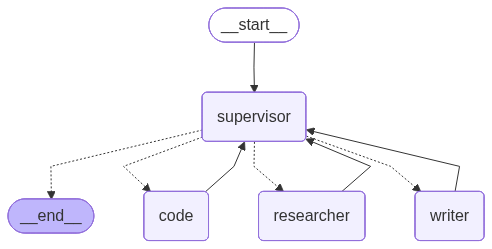

In [13]:
from IPython.display import Image, display

try:
    display(Image(multi_agent_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"⚠️ Graph-Visualisierung nicht verfügbar: {e}")

# 6 | Multi-Agent System testen
---

<p><font color='black' size='5'>
Beispiel 1: Research + Writing Task
</font></p>

In [ ]:
task1 = "Recherchiere Informationen über LangGraph und schreibe dann eine kurze Zusammenfassung (max. 100 Wörter)."

result = multi_agent_app.invoke({
    "messages": [HumanMessage(content=task1)],
    "next_agent": "",
    "task_complete": False
})

# Finale Antwort anzeigen
mprint("## 🎯 Multi-Agent Ergebnis")
mprint("---")
mprint(f"**Task:** {task1}")
mprint("\n**Arbeitsverlauf:**")
for msg in result["messages"]:
    agent_name = getattr(msg, 'name', 'User')
    mprint(f"- **{agent_name}:** {msg.content[:100]}...")


👔 SUPERVISOR: researcher
   Begründung: Die Anfrage erfordert zunächst eine Recherche über LangGraph, um relevante Informationen zu sammeln, bevor eine Zusammenfassung geschrieben werden kann.

🤖 RESEARCHER arbeitet...


<p><font color='black' size='5'>
Beispiel 2: Research + Code Task
</font></p>

In [ ]:
task2 = "Recherchiere die Fibonacci-Folge und schreibe dann Python-Code für eine Fibonacci-Funktion. Teste den Code."

result = multi_agent_app.invoke({
    "messages": [HumanMessage(content=task2)],
    "next_agent": "",
    "task_complete": False
})

mprint("## 🎯 Multi-Agent Ergebnis")
mprint("---")
mprint(f"**Task:** {task2}")
mprint("\n**Finale Ausgabe:**")
mprint(result["messages"][-1].content)

<p><font color='black' size='5'>
Beispiel 3: Komplexer Multi-Step Task
</font></p>

In [ ]:
task3 = """Aufgabe:
1. Recherchiere aktuelle Informationen zu OpenAI GPT-4
2. Schreibe einen strukturierten Blog-Artikel (mit Gliederung)
3. Erstelle Python-Code für ein einfaches GPT-4 API Beispiel
"""

result = multi_agent_app.invoke({
    "messages": [HumanMessage(content=task3)],
    "next_agent": "",
    "task_complete": False
})

mprint("## 🎯 Komplexer Multi-Agent Task")
mprint("---")
for i, msg in enumerate(result["messages"], 1):
    agent = getattr(msg, 'name', 'User')
    mprint(f"### Schritt {i}: {agent}")
    mprint(msg.content[:200] + "...\n")

# 7 | Vergleich: Single vs. Multi-Agent
---

| Aspekt | Single-Agent (M10) | Multi-Agent (M10b) |
|--------|-------------------|--------------------|
| **Spezialisierung** | ❌ Generalist | ✅ Spezialisierte Agents |
| **Komplexität** | ⚠️ Für komplexe Tasks überfordert | ✅ Teile-und-herrsche |
| **Debuggen** | ⚠️ Schwierig bei langen Prompts | ✅ Klare Verantwortlichkeiten |
| **Erweiterbarkeit** | ⚠️ Neue Features = längere Prompts | ✅ Neue Agents hinzufügen |
| **Latenz** | ✅ Schneller (ein LLM-Call) | ⚠️ Langsamer (mehrere Calls) |
| **Kosten** | ✅ Günstiger | ⚠️ Teurer |
| **Use Case** | Einfache, fokussierte Tasks | Komplexe, mehrstufige Workflows |

# 8 | Best Practices
---

<p><font color='black' size='5'>
Wann Multi-Agent verwenden?
</font></p>

✅ **VERWENDEN bei:**
- Komplexen Workflows mit mehreren Schritten
- Tasks die verschiedene Expertisen benötigen
- Wenn Spezialisierung wichtig ist (z.B. Legal + Tech)
- Enterprise-Scale Anwendungen

❌ **NICHT verwenden bei:**
- Einfachen, fokussierten Tasks
- Latenz-kritischen Anwendungen
- Budget-Beschränkungen
- Prototyping-Phase

<p><font color='black' size='5'>
Design-Tipps
</font></p>

**Agent-Anzahl:**
- ✅ Start: 2-4 Agents (überschaubar)
- ⚠️ Mehr als 7 Agents → Hierarchical Pattern

**Kommunikation:**
- ✅ Klare Agent-Namen in Messages
- ✅ Supervisor bekommt vollständigen Kontext
- ✅ Agents geben strukturierte Outputs

**Fehlerbehandlung:**
- ✅ Max. Iterationen begrenzen (z.B. 10)
- ✅ Timeout für einzelne Agents
- ✅ Fallback wenn Agent fehlschlägt

**Performance:**
- ✅ Caching von häufigen Research-Ergebnissen
- ✅ Parallele Agent-Ausführung wo möglich
- ✅ Kleinere Modelle für einfache Agents (z.B. gpt-4o-mini)

# A | Aufgaben
---

<p><font color='black' size='5'>
Aufgabe 1: Critique Agent hinzufügen
</font></p>

Erweitere das System um einen **Critique Agent**:

1. Erstelle einen Agent der Output von anderen Agents bewertet
2. Gibt Feedback als structured output: `{"score": int, "feedback": str, "approved": bool}`
3. Wenn `approved=False`: Zurück zum ursprünglichen Agent für Verbesserung
4. Maximal 2 Kritik-Schleifen pro Task

<p><font color='black' size='5'>
Aufgabe 2: Parallele Agent-Ausführung
</font></p>

Implementiere **parallele Research**:

1. Erstelle zwei Research-Agents:
   - `fast_researcher`: Nutzt nur Wikipedia (schnell)
   - `deep_researcher`: Nutzt Web-Search (gründlich)
2. Supervisor startet beide parallel
3. Aggregation-Node kombiniert Ergebnisse

**Hinweis:** Nutze `asyncio` für parallele Ausführung

<p><font color='black' size='5'>
Aufgabe 3: Hierarchical Multi-Agent System
</font></p>

Baue ein **2-Level Hierarchisches System**:

```
Chief Supervisor
     ├─ Research Team (Supervisor + 2 Researchers)
     └─ Content Team (Supervisor + Writer + Editor)
```

1. Chief Supervisor entscheidet zwischen Teams
2. Team-Supervisors koordinieren ihre Worker
3. Teste mit komplexem Task: "Erstelle einen umfassenden Report über Quantum Computing mit Code-Beispielen"

**Bonus:** Visualisiere den gesamten Workflow